<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_NLP_SpamClasiffier-2


### Spam Classification

[Spamming](https://en.wikipedia.org/wiki/Spamming) is the use of messaging systems to send multiple unsolicited messages (spam) to large numbers of recipients for the purpose of commercial advertising, for the purpose of non-commercial proselytizing, for any prohibited purpose (especially the fraudulent purpose of phishing), or simply sending the same message over and over to the same user. 

Spam Classification: Deciding whether an email is spam or not.



## Imports

In [1]:
# standard libraries
import pandas as pd
import numpy as np

In [2]:
# Scikit-learn is an open source machine learning library 
# that supports supervised and unsupervised learning
# https://scikit-learn.org/stable/
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
# Regular expression operations
#https://docs.python.org/3/library/re.html
import re 

# Natural Language Toolkit
# https://www.nltk.org/install.html
import nltk

# Stemming maps different forms of the same word to a common “stem” 
# https://pypi.org/project/snowballstemmer/
from nltk.stem import SnowballStemmer

# https://www.nltk.org/book/ch02.html
from nltk.corpus import stopwords

## Step 1: Load dataset

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# path to your (local/cloud) drive 
path = '/content/drive/MyDrive/Colab Notebooks/Enrique/Data/spam/'

# load dataset
df = pd.read_csv(path+'spam.csv', encoding='latin-1')
df.rename(columns = {'v1':'class_label', 'v2':'message'}, inplace = True)
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)

In [6]:
# original dataset
df.head()

,class_label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


The dataset has 4825 ham messages and 747 spam messages. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


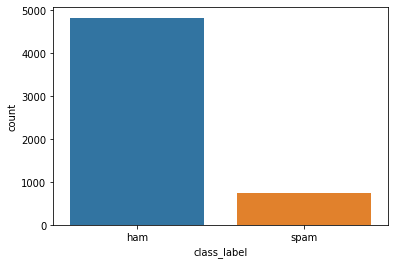

In [7]:
# histogram
import seaborn as sns
sns.countplot(df['class_label'])

In [8]:
# explore dataset
vc = df['class_label'].value_counts()
print(vc)

ham     4825
spam     747
Name: class_label, dtype: int64


This is an imbalanced dataset
* The number of ham messages is much higher than those of spam.
* This can potentially cause our model to be biased.
* To fix this, we could resample our data to get an equal number of spam/ham messages.

In [9]:
# convert class label to numeric
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df.class_label)
df2 = df
df2['class_label'] = le.transform(df.class_label)
df2.head()

,class_label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6f638a1c50>]],
      dtype=object)

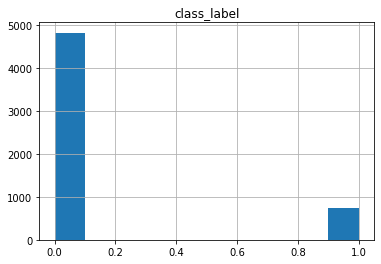

In [10]:
# another histogram
df2.hist()

## Step 2: Pre-processing

Next, we’ll convert our DataFrame to a list, where every element of that list will be a spam message. Then, we’ll join each element of our list into one big string of spam messages. The lowercase form of that string is the required format needed for our word cloud creation.

In [11]:
spam_list = df['message'].tolist()
spam_list

['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
 'Ok lar... Joking wif u oni...',
 "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
 'U dun say so early hor... U c already then say...',
 "Nah I don't think he goes to usf, he lives around here though",
 "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv",
 'Even my brother is not like to speak with me. They treat me like aids patent.',
 "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune",
 'WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.',
 'Had y

In [12]:
new_df = pd.DataFrame({'message':spam_list})

In [13]:
# removing everything except alphabets
new_df['clean_message'] = new_df['message'].str.replace("[^a-zA-Z#]", " ")

In [14]:
# removing short words
short_word = 4
new_df['clean_message'] = new_df['clean_message'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>short_word]))

In [15]:
# make all text lowercase
new_df['clean_message'] = new_df['clean_message'].apply(lambda x: x.lower())

In [16]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

swords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
# tokenization
tokenized_doc = new_df['clean_message'].apply(lambda x: x.split())

In [18]:
# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in swords])

In [19]:
# de-tokenization
detokenized_doc = []
for i in range(len(new_df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

In [20]:
new_df['clean_message'] = detokenized_doc

In [21]:
new_df.head()

,message,clean_message
0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis great world...
1,Ok lar... Joking wif u oni...,joking
2,Free entry in 2 a wkly comp to win FA Cup fina...,entry final receive entry question apply
3,U dun say so early hor... U c already then say...,early already
4,"Nah I don't think he goes to usf, he lives aro...",think lives around though


## Step 3: TfidfVectorizer

**[TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)**

Convert a collection of raw documents to a matrix of TF-IDF features.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features= 300, max_df=0.5, smooth_idf=True)
print(vectorizer)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.5, max_features=300,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)


In [23]:
X = vectorizer.fit_transform(new_df['clean_message'])
X.shape

(5572, 300)

In [24]:
y = df['class_label']
y.shape

(5572,)

Handle imbalance data through SMOTE 

In [25]:
from imblearn.combine import SMOTETomek 
smk= SMOTETomek()

X_bal, y_bal = smk.fit_sample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


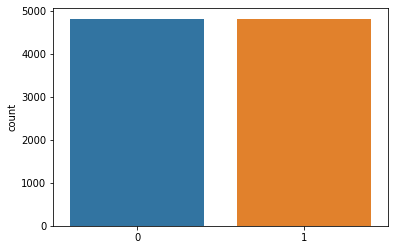

In [26]:
# histogram
import seaborn as sns
sns.countplot(y_bal)

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size = 0.20, random_state = 0)

In [28]:
X_train.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

## Step 4: Learning

Training the classifier and making predictions on the test set

In [29]:
# create a model
MNB = MultinomialNB()

# fit to data
MNB.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [30]:
# testing the model

prediction_train = MNB.predict(X_train)
print('training prediction\t', prediction_train)

prediction_test = MNB.predict(X_test)
print('test prediction\t\t', prediction_test)

training prediction	 [0 0 0 ... 1 0 0]
test prediction		 [1 1 1 ... 0 0 1]


In [31]:
np.set_printoptions(suppress=True)

# Ham and Spam probabilities in test
class_prob = MNB.predict_proba(X_test)
print(class_prob)

[[0.0172931  0.9827069 ]
 [0.45054822 0.54945178]
 [0.0025568  0.9974432 ]
 ...
 [0.77954955 0.22045045]
 [0.50323918 0.49676082]
 [0.28620661 0.71379339]]


In [32]:
# show emails classified as 'spam'
threshold = 0.5
spam_ind = np.where(class_prob[:,1]>threshold)[0]

## Step 5: Accuracy

In [33]:
# accuracy in training set
y_pred_train = prediction_train
print("Train Accuracy: "+str(accuracy_score(y_train, y_pred_train)))

Train Accuracy: 0.9182430681523711


In [34]:
# accuracy in test set (unseen data)
y_true = y_test
y_pred_test = prediction_test
print("Test Accuracy: "+str(accuracy_score(y_true, y_pred_test)))

Test Accuracy: 0.9139896373056995


In [35]:
# confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_test)
print("Confusion Matrix\n", conf_mat)

Confusion Matrix
 [[894  46]
 [120 870]]


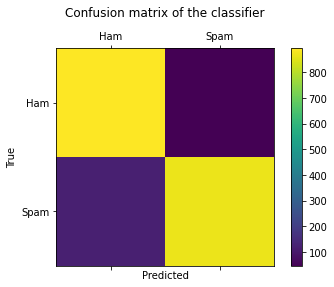

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

labels = ['Ham','Spam']

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat)
plt.title('Confusion matrix of the classifier\n')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()